---
title: "k-means"
format: html
---

This notebook uses data from the USGS Landsat 9 products. They are *not* distributed with the notebook because they are pretty large. We work from the `.dat` files that have been extracted from the raw data instead.

In [36]:
using Images
using CairoMakie
using Statistics
using DelimitedFiles
CairoMakie.activate!(; px_per_unit = 2)

The bands have been pre-processed, so we can load them directly:

In [64]:
R = readdlm("../data/kmeans/cooked/red.dat");
G = readdlm("../data/kmeans/cooked/green.dat");
B = readdlm("../data/kmeans/cooked/blue.dat");

This is enough to create a true color composite with the red, green, and blue channels:

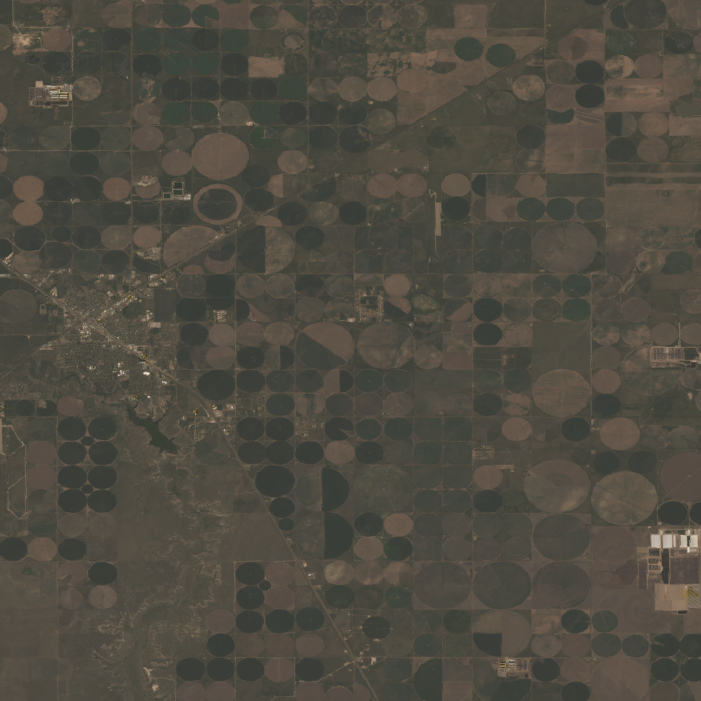

In [70]:
#| label: fig-visual
#| fig-cap: >
#|  The ...
cube = zeros(eltype(B), (3, size(B)...))
cube[1,:,:] .= R
cube[2,:,:] .= G
cube[3,:,:] .= B
rotl90(permutedims(colorview(RGB, cube.*2.75e-05)))

We also load the NIR and SWIR1 bands:

In [71]:
S = readdlm("../data/kmeans/cooked/swir.dat");
N = readdlm("../data/kmeans/cooked/nir.dat");

With these, we can do a vegetation fake color composite:

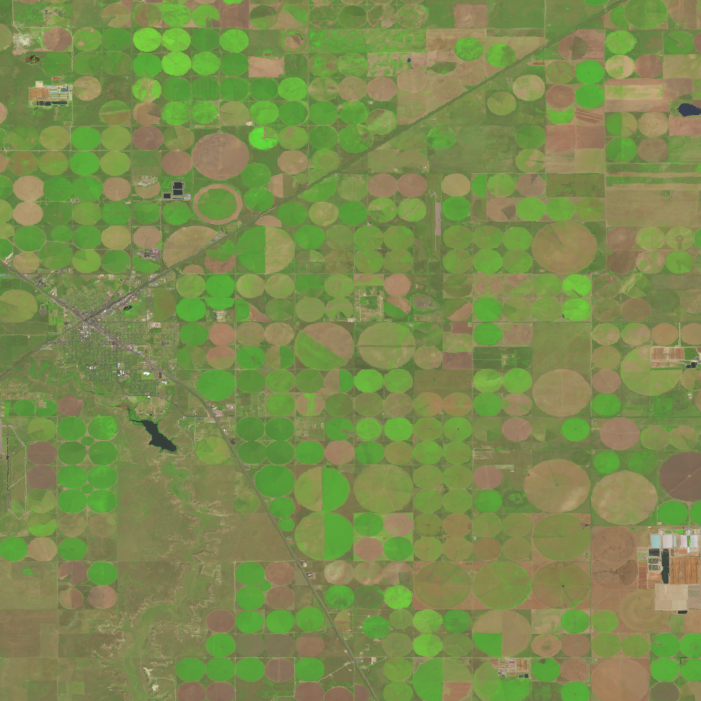

In [93]:
#| label: fig-color-veg
#| fig-cap: >
#|  The same landscape as above is now presented in a fake color composite, where SWIR is mapped to the red channel, NIR to the green channel, and red to the blue channel.
#|  This highlights different values in the landscape, but is no more or less "real" than the true color composite.
#|  It is a visualization of the data, that represents different choices, questions, and assumptions.
cube = zeros(eltype(B), (3, size(B)...))
cube[1,:,:] .= S
cube[2,:,:] .= N
cube[3,:,:] .= R
rotl90(permutedims(colorview(RGB, cube.*2.75e-05)))

We will not calculate the values of the NDVI, NDWI, and NDMI, which are normalized differences indices for respectively vegetation, water, and moisture:

In [73]:
ndvi = @. (N - R) / (N + R)
ndwi = @. (G - N) / (G + N)
ndmi = @. (N - S) / (N + S)

701×701 Matrix{Float64}:
 0.0260874  0.00968099  0.00968099  …  -0.0392418   -0.0392418  -0.0382184
 0.0227248  0.0227248   0.0130948      -0.0353589   -0.0375254  -0.0357745
 0.0212848  0.0212848   0.014759       -0.0447776   -0.0458534  -0.0414055
 0.021578   0.021578    0.0171556      -0.044926    -0.040826   -0.0401242
 0.0223966  0.0223966   0.0246513      -0.0454468   -0.0441078  -0.0431224
 0.01474    0.0101722   0.0218367   …  -0.0443405   -0.0436393  -0.044666
 0.0297397  0.0227995   0.0242872      -0.0451898   -0.0439113  -0.0453418
 0.0379933  0.0320085   0.0281832      -0.0424405   -0.0441899  -0.0464575
 0.0204882  0.0270181   0.0130101      -0.0356223   -0.041974   -0.0452769
 0.0284764  0.0190764   0.00573283     -0.0402049   -0.0401281  -0.042817
 ⋮                                  ⋱                            ⋮
 0.134428   0.113688    0.123412        0.0722543    0.116619    0.0671976
 0.160314   0.114019    0.108505        0.0417649    0.0938292   0.0532489
 0.180247 

In [74]:
X = zeros(Float32, (3, prod(size(ndvi))...))
X[1,:] .= vec(ndvi)
X[2,:] .= vec(ndwi)
X[3,:] .= vec(ndmi)

491401-element view(::Matrix{Float32}, 3, :) with eltype Float32:
 0.026087435
 0.022724759
 0.021284819
 0.021577975
 0.022396572
 0.014739975
 0.02973967
 0.03799328
 0.020488182
 0.028476443
 ⋮
 0.06719758
 0.053248942
 0.027211215
 0.048050415
 0.088570364
 0.10039498
 0.047792286
 0.03763054
 0.05717655

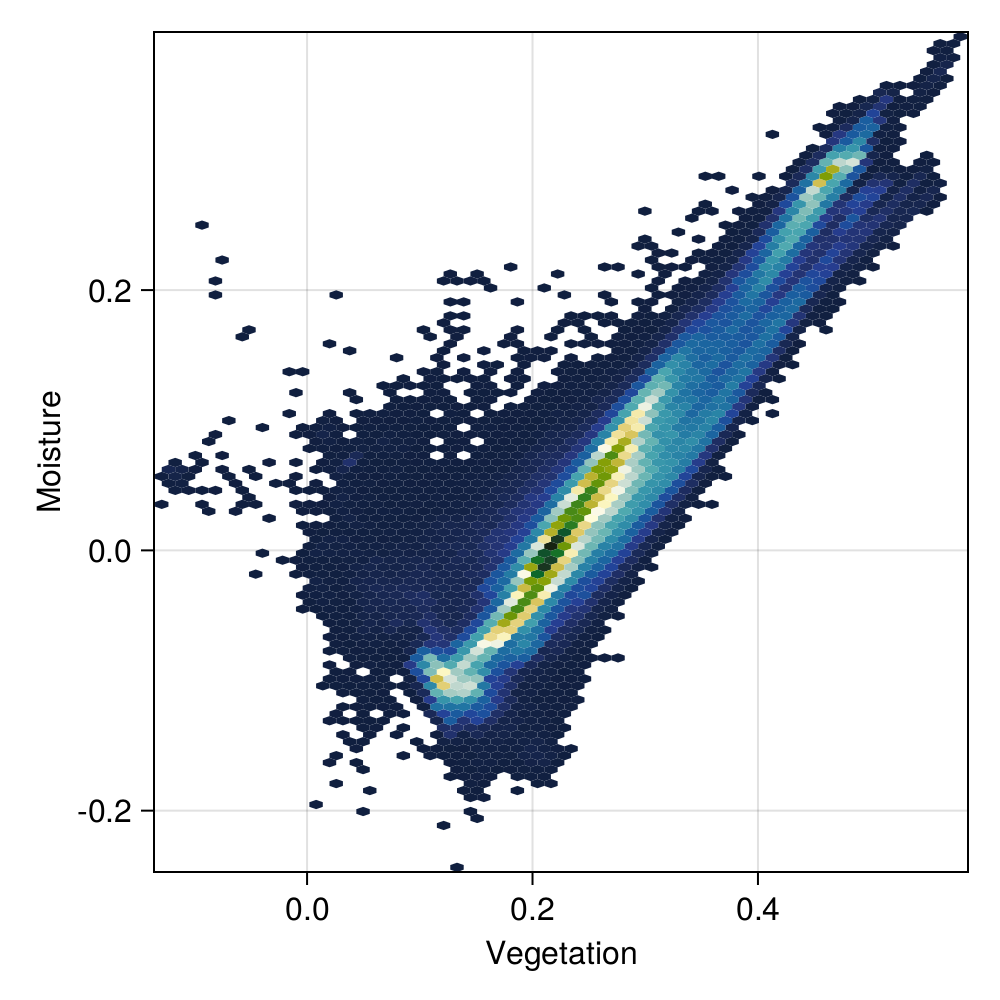

In [75]:
#| label: fig-hexbin
#| fig-cap: >
#|  The pixels acquired from Landsat 8 exist in a space with many different dimensions (one for each band).
#|  Because we are interested in a landscape classification based on water/vegetation data, we use the NDVI, NDMI, and NDWI 
#|  combinations of bands. These are *derived* data, and represent an instance of feature engineering: we have derived these values from the raw data.
fig = Figure(resolution=(500,500))
ax = Makie.Axis(fig[1,1]; xlabel="Vegetation", ylabel="Moisture")
hexbin!(ax, vec(ndvi), vec(ndmi), colormap=:delta, bins=120)
tightlimits!(ax)
current_figure()

We need a function for kmeans

In [84]:
using Clustering
clusters = kmeans(X, 5)

┌ Warning: The clustering cost increased at iteration #52
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #56
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


KmeansResult{Matrix{Float32}, Float32, Int64}(Float32[0.14076485 0.4565589 … 0.36475918 0.2830096; -0.20253342 -0.43247104 … -0.35790706 -0.29725835; -0.07706597 0.26380655 … 0.14656638 0.06643304], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3  …  5, 5, 5, 5, 5, 5, 4, 5, 5, 5], Float32[0.0010429025, 0.0008176863, 0.00073093176, 0.00074642897, 0.0007991791, 0.00045001507, 0.0012902617, 0.0022438318, 0.00076031685, 0.0011796206  …  0.0006547868, 0.00053834915, 0.00027549267, 0.0027765334, 0.0003888011, 0.0035847127, 0.0038009882, 0.0003799498, 0.0009160936, 0.00023719668], [81137, 68377, 140216, 69096, 132575], [81158, 68367, 140244, 69086, 132546], 1178.4368f0, 57, true)

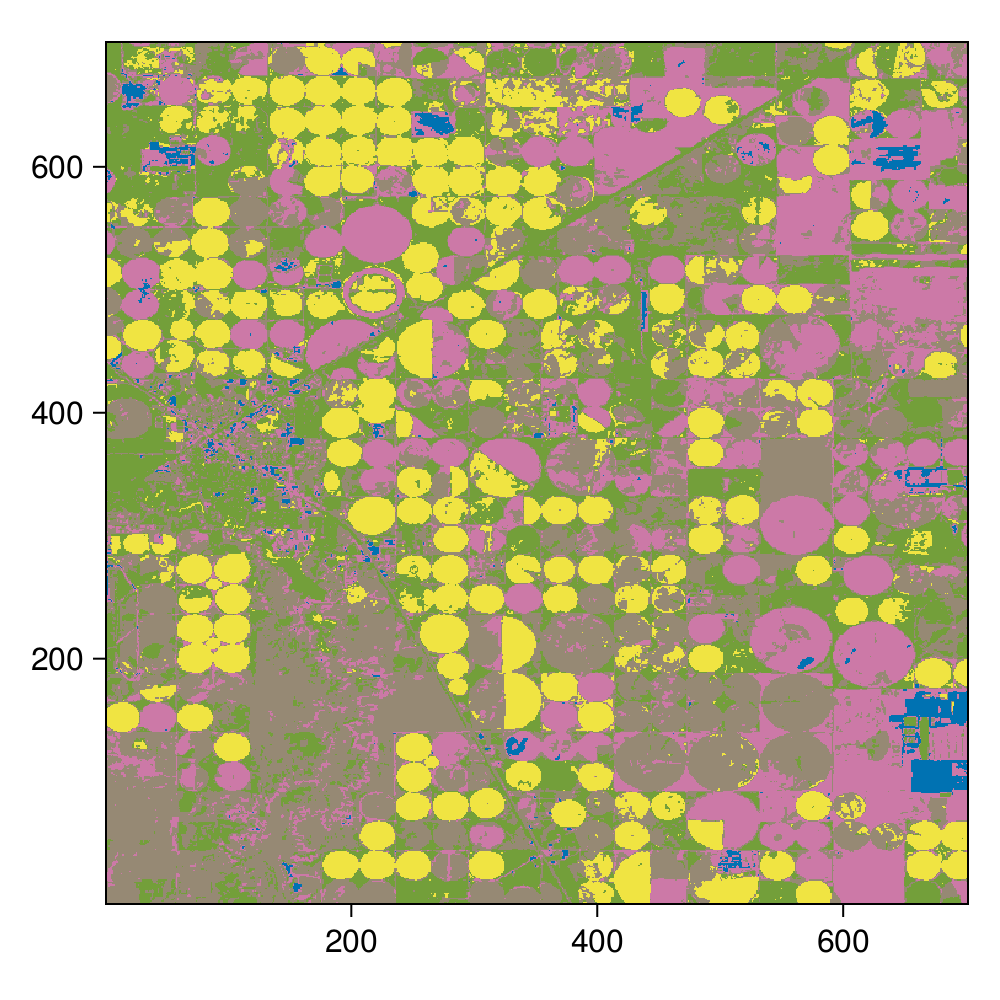

In [96]:
#| label: fig-classified-landscape
#| fig-cap: >
#|  After iterating the *k*-means algorithm, we obtain a classification for every pixel in the landscape.
#|  This classification is based on the values of NDVI and NDWI indices, and therefore groups pixels based on a specific hypothesis.
#|  This clustering was produced using a guessed value for the hyper-parameter $k=5$. 
C = reshape(assignments(clusters), size(ndvi))
fig = Figure(resolution=(500,500))
ax = Makie.Axis(fig[1,1]; aspect=DataAspect())
heatmap!(ax, permutedims(C); colormap=Makie.wong_colors())
current_figure()

In [78]:
function DaviesBouldin(X, C)
    centroids = C.centers
    assigns = C.assignments
    S = zeros(Float64, size(centroids, 2))
    M = zeros(Float64, (size(centroids, 2), size(centroids, 2)))
    for i in unique(assigns)
        this_cluster = findall(isequal(i), assigns)
        centr = centroids[:,i]
        pts = X[:,this_cluster]
        S[i] = mean(sqrt.([sum((centr .- pts[:,j]).^2.0) for j in axes(pts, 2)]))
        for j in unique(assignments(clusters))
            if i >=j
                M[i,j] = M[j,i] = sqrt(sum((centroids[:,i] .- centroids[:,j]).^2.0))
            end
        end
    end

    R = (S .+ S')./M
    D = mapslices(v -> maximum(filter(!isinf, v)), R; dims=2)
    return sum(D)/length(unique(assigns))
end

DaviesBouldin(X, clusters)

0.6903532524291326

In [100]:
current_min = Inf
best_k = Inf
for k in repeat(2:6, 5)
    DB = DaviesBouldin(X, kmeans(X, k))
    if DB < current_min
        current_min = DB
        best_k = k
        @info "New optimum: $k -- $DB"
    end
end

┌ Warning: The clustering cost increased at iteration #13
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #15
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #17
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #18
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #20
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #21
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Info: New optimum: 3 -- 0.8510054074487651
└ @ Main /home/tpoisot/Manuscripts/biodiversitymlfundamentals/notebooks/kmeans.ipynb:8
┌ Warning: The clustering cost increased at iteration #74
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #75
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #76
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #78
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #80
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #81
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #82
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #84
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #86
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #88
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #89
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #91
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Info: New optimum: 4 -- 0.8368376552502255
└ @ Main /home/tpoisot/Manuscripts/biodiversitymlfundamentals/notebooks/kmeans.ipynb:8


┌ Warning: The clustering cost increased at iteration #29
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #31
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #34
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #37
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #39
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #43
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #45
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #46
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #47
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #49
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #50
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #54
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #55
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #57
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #60
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #64
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #65
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #66
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #67
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #71
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #72
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #74
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #75
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #78
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #79
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #80
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #82
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Info: New optimum: 6 -- 0.6566686921338512
└ @ Main /home/tpoisot/Manuscripts/biodiversitymlfundamentals/notebooks/kmeans.ipynb:8


┌ Warning: The clustering cost increased at iteration #52
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #54
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #56
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #59
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #60
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #63
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #64
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #66
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #67
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #68
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #71
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #72
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #67
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #69
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #71
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #72
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #75
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #76
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #77
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #79
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #57
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #60
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #61
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #63
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #65
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #67
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #69
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #71
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #72
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #75
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #78
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #80
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #82
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #86
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #87
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #88
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #91
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #93
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #95
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #97
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #99
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #14
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #18
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #20
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #21
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #24
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #26
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #30
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #32
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #35
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #36
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #38
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #40
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #42
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #45
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #46
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #48
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #51
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #52
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #55
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #56
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #44
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #46
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #49
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #51
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #52
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #55
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #57
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #58
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #60
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #45
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #47
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #50
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #51
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #53
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #35
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #37
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #38
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #41
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #42
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #46
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #48
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Info: New optimum: 7 -- 0.6372932554464577
└ @ Main /home/tpoisot/Manuscripts/biodiversitymlfundamentals/notebooks/kmeans.ipynb:8
┌ Warning: The clustering cost increased at iteration #39
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #40
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #42
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #45
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #47
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #49
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #53
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #54
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #56
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #58
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #59
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #61
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #64
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #65
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #68
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #70
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #71
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #73
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #75
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #77
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #78
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #79
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #42
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #44
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #48
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #50
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #51
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #54
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #57
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #58
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #60
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #61
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #64
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #66
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #68
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #70
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #72
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #73
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #76
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #77
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #79
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #81
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #83
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #85
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #87
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #89
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #23
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #26
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #29
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #24
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #27
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #28
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #29
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #30
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #32
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #34
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #36
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #38
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #40
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #41
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #42
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #44
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #16
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #17
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #21
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #22
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #24
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #25
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #27
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #29
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #30
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #33
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #24
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #26
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #28
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #29
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #32
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #33
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #35
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #37
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #39
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #40
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #41
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #43
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #44
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #48
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #80
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #82
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #84
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #93
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #95
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #97
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #99
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #45
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #47
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #53
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #58
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #60
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #62
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #66
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #67
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #69
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #71
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #73
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #76
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #79
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #81
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #84
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #85
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #86
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #88
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #89
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #90
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #91
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #93
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #95
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #98
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #100
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #21
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #23
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #24
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #25
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #26
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #28
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #43
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #45
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #47
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #48
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #49
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #50
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #51
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #54
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #55
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #57
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #58
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #59
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #62
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #27
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #30
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #31
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #34
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #35
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #37
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #38
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #40
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #42
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #46
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #48
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #32
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #35
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #38
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #42
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #43
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #48
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #49
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #50
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #52
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #55
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #58
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #60
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #61
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #67
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #69
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #71
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #72
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #73
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #75
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #55
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #57
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #60
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #61
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #63
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #67
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #69
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #70
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #71
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #73
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #75
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #78
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #80
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #83
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #84
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #58
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #62
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #64
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #67
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #73
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #76
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #82
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #84
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #87
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #88
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #90
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #91
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #94
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #98
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #13
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #16
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #18
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #19
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #22
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #20
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #22
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #23
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #25
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #41
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #42
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #44
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #46
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #48
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #49
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #51
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #53
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #54
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #56
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #58
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #34
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #42
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #45
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #47
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #48
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #50
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #51
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #54
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #56
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #57
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #60
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #65
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #67
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #68
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #70
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #71
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #74
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #76
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #49
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #52
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #55
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #58
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #59
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #60
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #62
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #64
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #66
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #69
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #70
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #71
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #72
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #74
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #77
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #79
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #86
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #91
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #95
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #97
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #99
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


In [101]:
k = best_k
clusters = kmeans(X, k)
best_score = DaviesBouldin(X, clusters)
for i in 1:10
    tentative = kmeans(X, k)
    db = DaviesBouldin(X, tentative)
    if db < best_score
        clusters = tentative
        best_score = db
        @info "New optimum $db"
    end
end

┌ Warning: The clustering cost increased at iteration #64
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #67
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #69
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #70
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #71
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #73
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #74
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #88
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #90
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #93
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #96
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #98
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #100
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #30
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #37
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #39
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #41
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #46
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #50
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #51
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #52
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #56
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #57
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #59
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #60
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #62
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #64
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #66
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #68
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #70
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #72
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #74
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #76
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #78
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #80
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #82
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #84
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #86
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #88
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #90
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #92
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #94
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #96
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #98
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #100
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #89
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #92
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #95
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #97
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #98
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #100
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #70
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #71
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #73
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #75
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #77
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #79
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #81
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #83
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #85
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #86
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #90
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #91
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #92
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #94
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #97
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #98
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #32
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #34
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #37
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #39
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #41
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #44
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #46
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #49
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #51
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #54
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #55
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #58
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #61
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #25
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #28
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #29
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #31
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #32
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #35
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #38
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #39
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #41
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #45
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #47
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #48
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #51
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #53
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #55
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #59
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #60
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #61
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #63
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #65
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #69
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #70
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #34
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #38
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #40
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #41
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #43
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #47
└ @ Clustering /home/tpoisot/.julia/packages/Clustering/yuxBr/src/kmeans.jl:191


InterruptException: Error trying to display an error.

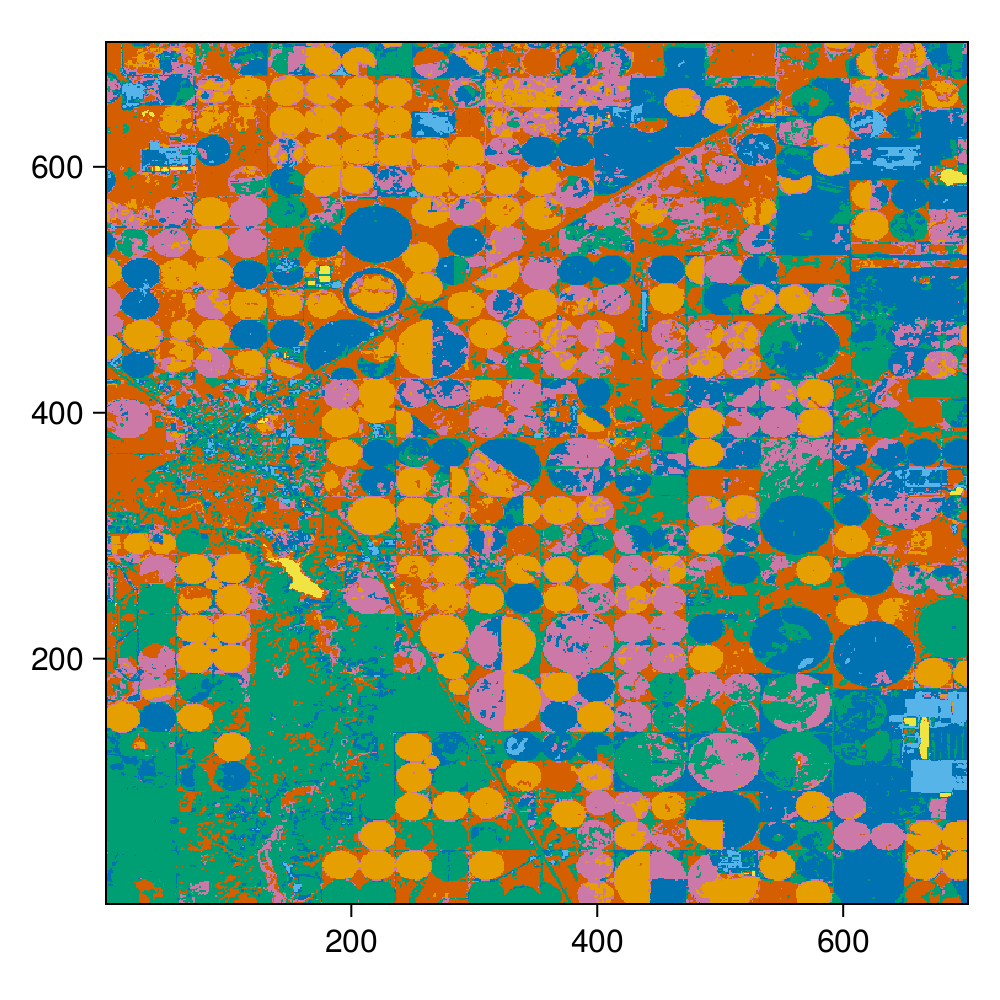

In [103]:
#| label: fig-optimal-landscape
#| fig-cap: >
#|  Classification of the landscape after picking the optimal value of the hyperparameter $k$,
#|  and by repeating the clustering process at this value of *k* several times. The optimal value, *i.e.* the one with
#|  the lowest Davies-Bouldin index, is presented.
C = reshape(assignments(clusters), size(ndvi))
fig = Figure(resolution=(500,500))
ax = Makie.Axis(fig[1,1]; aspect=DataAspect())
heatmap!(ax, permutedims(C); colormap=Makie.wong_colors())
current_figure()

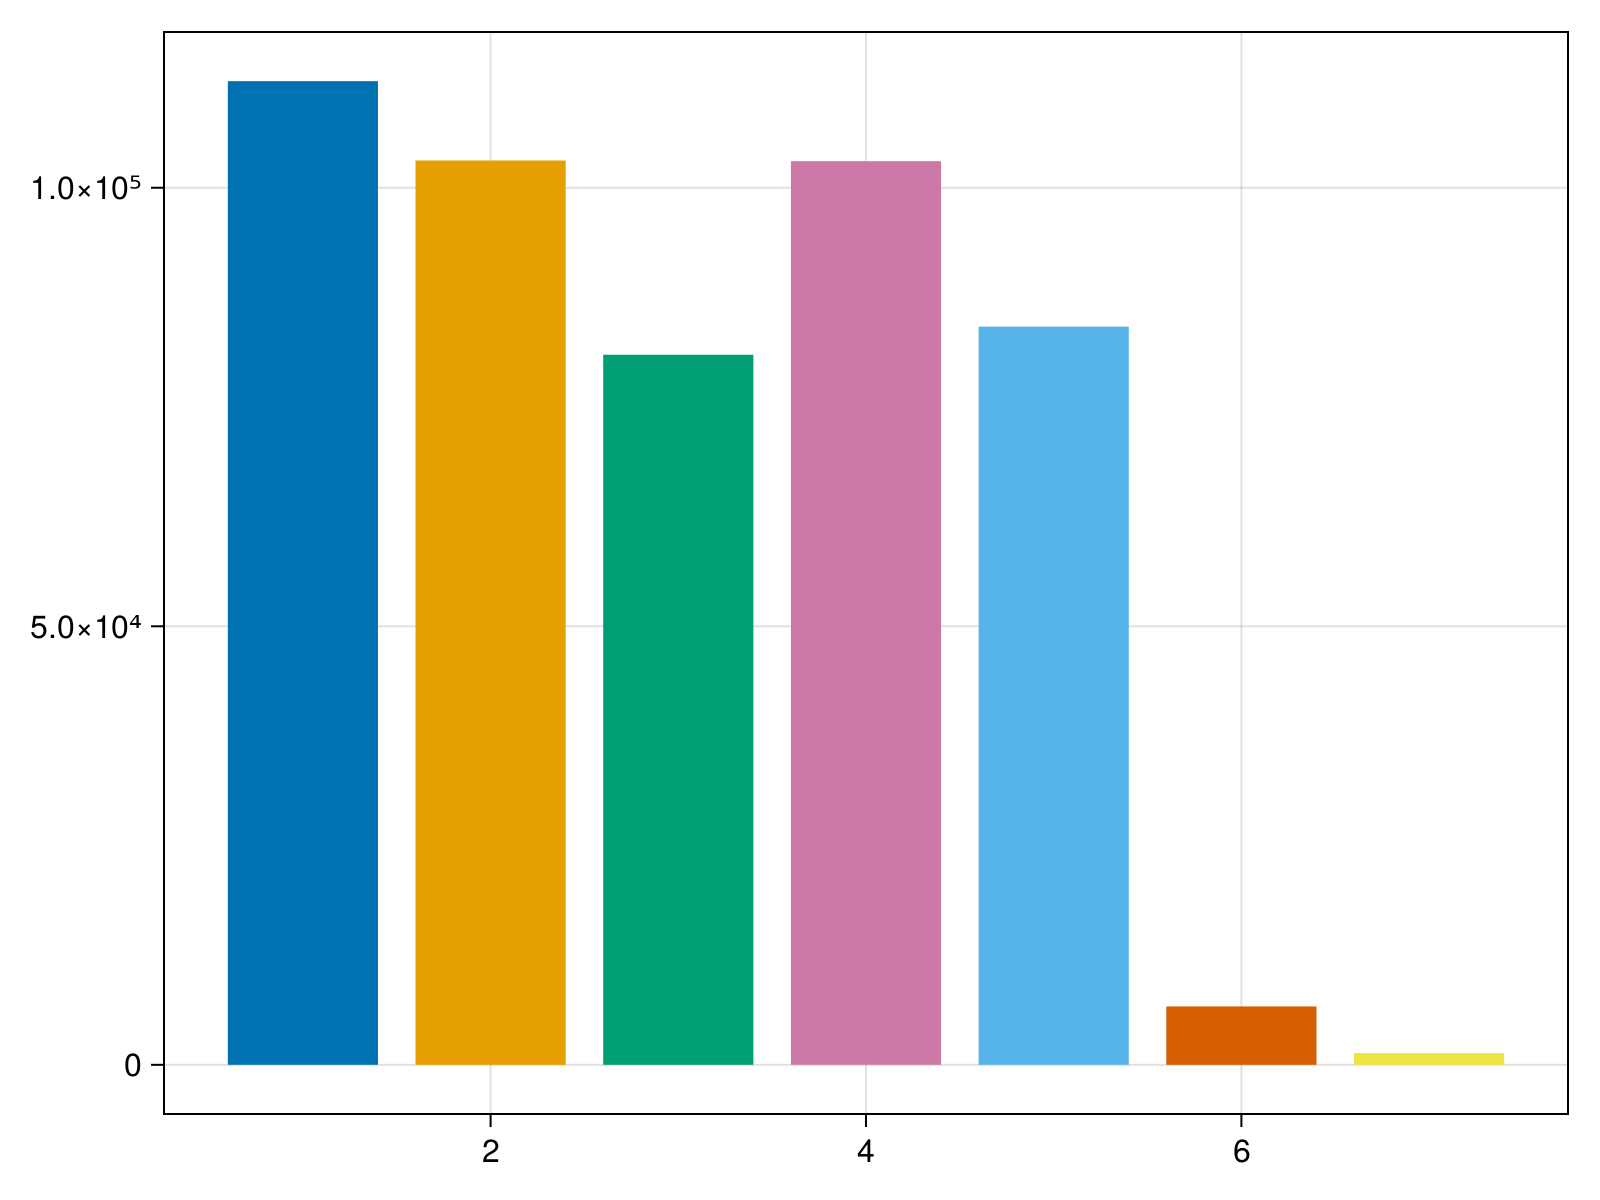

In [110]:
#| label: fig-barplot-classes
#| fig-cap: >
#|  Number of pixels assigned to each class in the final landscape classification.
assigns = clusters.assignments
clust = unique(assigns)
counts = [count(isequal(k), assigns) for k in clust]
barplot(counts, color=Makie.wong_colors())